# CerealTimeKillersNet: Deep neural network for emotional states predictions from EEG data.

## Package setup

In [1]:
# Basic packages
import time
import random
import numpy as np
import pandas as pd

# Math packages
import math
from scipy.signal import spectrogram

# Plot packages
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset, SubsetRandomSampler, random_split

# ML Packages
from sklearn.model_selection import KFold


## Basic functions setup

In [2]:
# Set random seed
# Executing `set_seed(seed=seed)` you are setting the seed to ensure reproducibility.
# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

def set_seed(seed = None, seed_torch = True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


In [3]:
# @title Set device (GPU or CPU). Execute `set_device()` especially if torch modules used.
# inform the user if the notebook uses GPU or CPU.

def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("WARNING: For this notebook to perform best, "
            "if possible, in the menu under `Runtime` -> "
            "`Change runtime type.`  select `GPU` ")
    else:
        print("GPU is enabled in this notebook.")

    return device


In [4]:
# plot settings

def plot_loss_accuracy(train_loss, val_loss, test_loss, train_acc, val_acc, test_acc):
    epochs = len(train_loss)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label = 'Training')
    ax1.plot(list(range(epochs)), val_loss, label = 'Validation')
    ax1.plot(list(range(epochs)), test_loss, label = 'Testing')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label = 'Training')
    ax2.plot(list(range(epochs)), val_acc, label = 'Validation')
    ax2.plot(list(range(epochs)), test_acc, label = 'Testing')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    
    fig.set_size_inches(15.5, 5.5)
    plt.show()
    

In [5]:
# Norm
def calculate_frobenius_norm(model):
    norm = 0.0
    for param in model.parameters():
        norm += torch.sum(param ** 2)
    norm = norm ** 0.5
    return norm

def L1_norm(model):
    return sum(p.abs().sum() for p in model.parameters())

def L2_norm(model):
    return sum((p**2).sum() for p in model.parameters())


In [6]:
# Maximum label comparison for accracy

def maximum_extraction(tens, eplison = 1e-8):
    l_index = []
    for i in range(tens.shape[0]):
        label = tens[i].detach().numpy()
        l = []
        for j in range(len(label)):
            if label[j] > max(label) - eplison:
                l.append(j)
        l_index.append(l)
    return l_index
    
def maximum_comparison(list1, list2): # list2 is supposed to be real labels with multiple maximum values
    tot = 0
    for i in range(len(list1)):
        for j in range(len(list1[i])):
            if list1[i][j] in list2[i]:
                tot += 1
                break
    return tot


## DataLoader setup

In [7]:
class CerealTimeKillersDataset(Dataset):
    """Spectrogram dataset for torch"""

    def __init__(self, df, transform = None):
        self.ori_dataframe = df
        self.transform = transform

    def __len__(self):
        return len(self.ori_dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        spectrogram = self.ori_dataframe.iloc[idx, -1]
        spectrogram = torch.tensor(spectrogram)
        if self.transform:
            spectrogram = self.transform(spectrogram)
        
        labels = self.ori_dataframe.iloc[idx, :-1]
        labels = torch.tensor(labels).type(torch.FloatTensor)
        if self.transform:
            labels = self.transform(labels)
        
        return (spectrogram, labels)
    

In [8]:
def get_specgram(df, labels, winlen = None, stride = 1, nperseg = 256, fs = 129):
    """
    Spectrogram from EEG data
    
    Inputs:
    df (pandas.DataFrame): EEG dataframe
    labels (CerealTimeKillersLabels): Electrode labels used for model prediction
    winlen (None/int): Time window for input sampling (for the whole timepoints, Default is None)
    stride (int): Temporal leap for input sampling (Default is 1)
    nperseg (int): N per seg of spectrogram (Default is 256)
    fs (int): Framerate of spectrogram (Default is 128)
    
    Returns:
    data (np.array): EEG data spectrogram with [samplepoint, frequency, time, channel]
    """
    
    # Load selected electrodes
    df = pd.DataFrame(df, columns = labels)
    d = np.array(df, dtype = float) # Switching from pandas to numpy array as this might be more comfortable for people
    
    full_spec = []
    for idx, d2 in enumerate(d.T):
        _, _, Sxx = spectrogram(d2, nperseg = nperseg, fs = fs)
        full_spec.append(Sxx)
        
    #DIMENSIONS OF FULL_SPEC WITHOUT WINDOWING (I.E. FULL WINDOWING)
    #DIMENSION 1: 1                      - FOR DIMENSIONAL CONSISTENCY
    #DIMENSION 2: CHANNELS  (DEFAULT=14) - MIGHT CHANGE (SO NOT REALLY DEFAULT BUT OK)
    #DIMENSION 3: FREQUENCY (DEFAULT=129)
    #DIMENSION 4: TIME      (DEFAULT=170) - MIGHT CHANGE AS WELL OK - WE ARE WORKING ON IT
    
    full_spec = np.vstack([full_spec])
    full_spec = np.moveaxis(full_spec, 0, 0)
    if winlen == None:
        return np.array([full_spec])
    
    i = 0
    full_spec_wind = []
    # STRICK THE FOLLOWING LOOP ON THE TIME (WINDOW) DIMENSION!
    while i * stride + winlen < full_spec.shape[2]:
        full_spec_wind.append(full_spec[: , : , i * stride : i * stride + winlen])
        i += 1
    
    #DIMENSIONS OF FULL_SPEC WITH WINDOWING    (FULL_SPEC_WIND) 
    #DIMENSION 1: SAMPLE    (NO DEFAULT - SORRY)
    #DIMENSION 2: CHANNELS  (DEFAULT=14) - MIGHT CHANGE (SO NOT REALLY DEFAULT BUT OK)
    #DIMENSION 3: FREQUENCY (DEFAULT=129)
    #DIMENSION 4: WINDOWS   (DEFAULT=1)
    
    full_spec_wind = np.array(full_spec_wind)
    return full_spec_wind


In [9]:
def CerealTimeKillersDataLoader(dir_base, label_class, label_range, 
                                dataset_mix = True, 
                                winlen = None, stride = 1, nperseg = 256, fs = 129,
                                transform = None):
    """
    Cereal Time Killers Data Loader
    
    Inputs:
    dir_base (str): Working space dictionary
    label_class (CerealTimeKillersLabels): Labels used for model prediction
    label_range (1*2 list): The [min, max] of emotional states for transformation
    dataset_mix (bool): Whether to allow between-subject and between-game dataset mixture (Default is True)
    winlen (None/int): Time window for input sampling (for the whole timepoints, Default is None)
    stride (int): Temporal leap for input sampling (Default is 1)
    nperseg (int): N per seg of spectrogram (Default is 256)
    fs (int): Framerate of spectrogram (Default is 128)
    transform (torchvision.transforms.transforms.Compose): Torch transormfation (Default is None)
    
    Returns:
    FullDataset (CerealTimeKillersDatase list): full data with EEG spectrogram and fixed labels (information and/or emotional states) in CerealTimeKillersLabels
        FullDataset[i]: ith datapoint of [spectrogram, labels]
    DataSize (Tuple): Data size for single point as (Input size as tuple, Output size as int)
    ExpIndex (pandas.DataFrame): Corresponsing subject and game (as two columns) with shared row indices from FullDataset
    """
    
    specgram_name = 'full_specgram_1'
    
    # Load label & EEG data
    labels_df = pd.read_csv(f'{dir_base}GameLabels.csv')
    spec_df = pd.DataFrame(columns = label_class.fixed + [specgram_name], dtype = float)
    index_df = pd.DataFrame(columns = ['subject', 'game'], dtype = int)
    
    # Create spectrogram dataframe
    for idx in range(labels_df.shape[0]): 
        
        # Load info and fixed labels
        subject = labels_df['subject'].iloc[idx]
        game = labels_df['game'].iloc[idx]
        fixed_labels = labels_df[label_class.fixed].iloc[idx]
        fixed_labels = list(np.array(np.array(fixed_labels, dtype = 'float') - label_range[0]) / (label_range[1] - label_range[0]))
        
        # You can also just paste in the Directory of the csv file - on windows you may have to change the slash direction
        DirComb = f'{dir_base}GAMEEMO/(S{str(subject).zfill(2)})/Preprocessed EEG Data/.csv format/S{str(subject).zfill(2)}G{str(game)}AllChannels.csv'
        CsvSpec = pd.read_csv(DirComb, sep = ',')
        
        # Get EEG spectrogram
        spec_EEG = get_specgram(CsvSpec, label_class.electrode, 
                                winlen = winlen, stride = stride, nperseg = nperseg, fs = fs)
        
        # Add new data to dataframe
        new_spec_list, new_index_list = list(), list()
        if dataset_mix:
            for i in range(spec_EEG.shape[0]):
                new_spec_list.append(fixed_labels + [spec_EEG[i]])
                new_index_list.append([subject, game])
        else:
            new_spec_list.append(fixed_labels + [spec_EEG])
            new_index_list.append([subject, game])
        
        # Update dataframe
        new_spec_df = pd.DataFrame(new_spec_list, columns = label_class.fixed + [specgram_name], dtype = float)
        spec_df = pd.concat([spec_df, new_spec_df], ignore_index = True)    
        new_index_df = pd.DataFrame(new_index_list, columns = ['subject', 'game'], dtype = int)
        index_df = pd.concat([index_df, new_index_df], ignore_index = True)
    
    # Output
    final_df = CerealTimeKillersDataset(df = spec_df, transform = transform)
    data_size = (tuple(final_df[0][0].shape), tuple(final_df[0][1].shape))

    return final_df, data_size, index_df


In [10]:
def CerealTimeKillersDataSplitter(full_dataset, exp_index, 
                                  allocation_test = None, 
                                  test_ratio = 0.2, target_test = [], k_folds = 10, 
                                  batch_size_train = 16, batch_size_test = 32, 
                                  seed = 0, generator = None):
    """
    Cereal Time Killers Data Splitter
    
    Inputs:
    full_dataset (CerealTimeKillersDataset): full data with EEG spectrogram and experimental labels (information and emotional states)
        full_dataset[i]: ith data for a specific subject and game of {'spectrogram': spectrogram, 'labels': labels}
    exp_index (pandas.DataFrame): Corresponsing subject and game (as two columns) with shared row indices from full_dataset
    allocation_test (None/str): Which to be based for allocating testing dataset (Default is None) # [None, 'subject', 'game']
    test_ratio (float) Proportion of data used for testing when Allocation_test == None (Default is 0.2)
    target_test (list): Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None (Default is [])
    k_folds (int): Number for K-folds for training vs validation (Default is 10)
    batch_size_train (int): Number of examples per minibatch during training (Default is 16)
    batch_size_test (int): Number of examples per minibatch during validation/testing (Default is 1)
    seed (int): Random seed for reproducibility (Default is 0)
    generator (torch._C.Generator): Torch generator for reproducibility (Default is None)
    
    Returns:
    SplittedDataset (dict): Full dataset splitted in {'train': training, 'val': validation, 'test': testing}
        SplittedDataset['train'][fold].dataset (CerealTimeKillersDataset): Training dataset in nth fold
        SplittedDataset['val'][fold].dataset (CerealTimeKillersDataset): Validation dataset in nth fold
        SplittedDataset['test'].dataset (CerealTimeKillersDataset): Testing dataset outside folds
    SplittedDataLength (dict): Length of dataset in {'train': training, 'val': validation, 'test': testing}
    """
    
    # Split into train/val and test datasets
    train_set_index, test_set_index = list(), list()
    if allocation_test == None:
        test_size = int(test_ratio * len(full_dataset))
        train_size = len(full_dataset) - test_size
        train_set_orig, test_set_orig = random_split(full_dataset, 
                                                     [train_size, test_size], 
                                                     generator = generator)
    elif (allocation_test == 'subject') or (allocation_test == 'game'):
        train_set_index = exp_index[~exp_index[allocation_test].isin(target_test)].index.tolist()
        test_set_index = exp_index[exp_index[allocation_test].isin(target_test)].index.tolist()
        train_set_orig = Subset(full_dataset, train_set_index)
        test_set_orig = Subset(full_dataset, test_set_index)
    else:
        print("Allocate testing dataset based on one of the 'Subject', 'Game', or None.")
        return None
    
    # Test dataset loader
    test_loader = DataLoader(test_set_orig,
                             batch_size = batch_size_test,
                             num_workers = 0,
                             generator = g_seed)
    
    # K-fold Cross Validator
    train_loader, val_loader = [[]] * k_folds, [[]] * k_folds
    kfold = KFold(n_splits = k_folds, shuffle = True, random_state = seed)
    for fold, (train_i, val_i) in enumerate(kfold.split(train_set_orig)):
        
        # Sample train/test dataset from indices
        train_sampler = SubsetRandomSampler(train_i, generator = g_seed)
        val_sampler = SubsetRandomSampler(val_i, generator = g_seed)
        
        # Train/Validation dataset loader
        train_loader[fold] = DataLoader(train_set_orig,
                                        sampler = train_sampler,
                                        batch_size = batch_size_train,
                                        num_workers = 0,
                                        generator = generator)
        val_loader[fold] = DataLoader(train_set_orig,
                                      sampler = val_sampler,
                                      batch_size = batch_size_test,
                                      num_workers = 0,
                                      generator = generator)
    
    # return datasplitter
    data_loader = {'train': train_loader, 'val': val_loader, 'test': test_loader}
    data_length = {'train': len(train_sampler), 'val': len(val_sampler), 'test': len(test_set_orig)}
    return data_loader, data_length


## Neural network setup

In [11]:
def train(args, model, train_loader, optimizer = None, criterion = nn.MSELoss()):
    
    model.train()

    for (data, target) in train_loader:
        data, target = data.type(torch.float).to(args['device']), target.type(torch.float).to(args['device'])
        optimizer.zero_grad() 
        output = model(data)
        
        loss = criterion(output, target) + args['l1'] * L1_norm(model) + args['l2'] * L2_norm(model)
        loss.backward()
        
        optimizer.step()


In [23]:
def test(args, model, test_loader, criterion = nn.MSELoss()):
    
    model.eval()
    
    eval_loss = 0.0
    acc = 0.0
    total = 0
    with torch.no_grad():
        for (data, target) in test_loader:
            data, target = data.type(torch.float).to(args['device']), target.type(torch.float).to(args['device'])
            output = model(data)
            
            loss = criterion(output, target)
            eval_loss += loss.item()
            
            predicted = maximum_extraction(output)
            labels = maximum_extraction(target)
            acc += maximum_comparison(predicted, labels)
            total += target.size(0)
            
    return eval_loss / len(test_loader), acc * 100 / total


In [13]:
def simulation(args, model, train_loader, val_loader, test_loader, 
                                    optimizer = None, criterion = nn.MSELoss()):
    
    model = model.to(args['device'])
    
    val_loss_list, train_loss_list, test_loss_list = [], [], []
    val_acc_list, train_acc_list, test_acc_list = [], [], []
    param_norm_list = []
    for epoch in tqdm(range(args['epochs'])):
        
        train(args, model, train_loader, optimizer = optimizer, criterion = criterion)
        param_norm = calculate_frobenius_norm(model)
        
        train_loss, train_acc = test(args, model, train_loader, criterion = criterion)
        val_loss, val_acc = test(args, model, val_loader, criterion = criterion)
        test_loss, test_acc = test(args, model, test_loader, criterion = criterion)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        test_acc_list.append(test_acc)
        param_norm_list.append(param_norm)
        
        if ((epoch + 1) % 10 == 0) or (epoch + 1 == args['epochs']):
            print('-----Epoch ', epoch + 1, '/', args['epochs'])
            print('Train/Val/TEST MSE:', train_loss, val_loss, test_loss)
            print('Train/Val/TEST Accuracy:', train_acc, val_acc, test_acc)

    plot_loss_accuracy(train_loss_list, val_loss_list, test_loss_list, train_acc_list, val_acc_list, test_acc_list)

    return (train_loss_list, val_loss_list, test_loss_list), (train_acc_list, val_acc_list, test_acc_list), param_norm_list, model


In [14]:
# Main function of model simulation
def CerealTimeKillersModelSimulator(args, TrainDataLoader, ValDataLoader, TestDataLoader, DataSize,
                                    K_fold_train = False, k_folds = 1):
    
    N_FOLD = k_folds if K_fold_train else 1
    loss, acc, param, models = [], [], [], []
    
    for fold in range(N_FOLD):
        print('\n%d/%d Fold' % (fold + 1, N_FOLD))
        print('----------------------------')
    
        model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
        loss_list, acc_list, param_norm_list, trained_model = simulation(args, model,
                                                                         TrainDataLoader[fold],
                                                                         ValDataLoader[fold],
                                                                         TestDataLoader,
                                                                         optimizer = optimizer,
                                                                         criterion = criterion)
    
        loss_list, acc_list = np.array(loss_list), np.array(acc_list)
        loss.append([loss_list[0, -1], loss_list[1, -1], loss_list[2, -1]])
        acc.append([np.max(acc_list[0]), np.max(acc_list[1]), np.max(acc_list[2])])
        param.append(param_norm_list[-1])
        models.append(trained_model)
    
    print('Train/Val/Test Final MSE:', list(loss[-1]))
    print('Train/Val/Test Maximum Accuracy:', list(acc[-1]))
    
    return loss, acc, param, models


## Model settings - Change models here!

In [15]:
class CTKNet(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTKNet, self).__init__()
        
        # Model hyperparametres (layer by layer)
        conv_channel = [5, 5]
        conv_kernel = [3, 10]
        pool_kernel = [2, 2]
        fc_unit = [128]
        drop_out = [0.5]
        
        # Hidden layers
        img_size = np.array(input_shape[1:])
        
        self.conv1 = nn.Conv2d(in_channels = input_shape[0], out_channels = conv_channel[0], kernel_size = conv_kernel[0])
        self.pool1 = nn.MaxPool2d(kernel_size = pool_kernel[0])
        img_size = np.floor((img_size - conv_kernel[0] + 1.0) / pool_kernel[0])
        
        self.conv2 = nn.Conv2d(in_channels = conv_channel[0], out_channels = conv_channel[1], kernel_size = conv_kernel[1])
        self.pool2 = nn.MaxPool2d(kernel_size = pool_kernel[1])
        img_size = np.floor((img_size - conv_kernel[1] + 1.0) / pool_kernel[1])
        
        fc_input_size = int(np.prod(img_size) * conv_channel[1])
        
        self.fc1 = nn.Linear(in_features = fc_input_size, out_features = fc_unit[0])
        self.drop1 = nn.Dropout(drop_out[0])
        
        self.fc2 = nn.Linear(in_features = fc_unit[0], out_features = out_size[0])
    

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.drop1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x


In [16]:
class YourNet(nn.Module):
    def __init__(self, input_shape, out_size):

        super(YourNet, self).__init__()
        
        # Model hyperparametres (layer by layer)
        ...
        
        # Hidden layers
        ...

    def forward(self, x):
        ...
        
        return x


In [17]:
# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTKNet(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


## Input settings - Change hypermatres here!

In [18]:
class CerealTimeKillersLabels:
    """
    Select labels for model prediction
    Labels used for prediction: info + electrode --> prediction
    CHANGE these with necessity before loading data
    """
    
    # ['subject', 'game', 'gender', 'age', 'disturbance', 'experience', 'memory']
    info = []
        
    # ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    electrode = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
        
    # ['satisfied', 'boring', 'horrible', 'calm', 'funny', 'valence', 'arounsal']
    prediction = ['boring', 'horrible', 'calm', 'funny']
    # prediction = ['valence', 'arounsal']
    
    # Fixed variables
    fixed = info + prediction
    
    # Summarise labels for model
    label = info + electrode + prediction
    

In [19]:
# General settings
workspace_dir = '' # Workspace directionary
LabelRange = [1, 10] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = True # Default is True for 3-dimensional input

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = None # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = N_inputtime # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 150,
    'lr': 1e-4,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None


Current device: cpu
Random seed 2021 has been set.


## MAIN CODE

In [20]:
# Implement Dataloader
FullDataset, DataSize, ExpIndex = CerealTimeKillersDataLoader(dir_base = workspace_dir,
                                                              label_class = CerealTimeKillersLabels,
                                                              label_range = LabelRange,
                                                              dataset_mix = Is_between_subject,
                                                              winlen = N_inputtime,
                                                              stride = N_stridetime,
                                                              nperseg = N_perseg,
                                                              fs = N_framerate,
                                                              transform = data_transform)

# Implement DataSplitter
SplittedDataset, SplittedDataLength = CerealTimeKillersDataSplitter(FullDataset, 
                                                                    exp_index = ExpIndex, 
                                                                    allocation_test = Allocation_test,
                                                                    test_ratio = test_ratio,
                                                                    target_test = Target_test,
                                                                    k_folds = k_folds,
                                                                    batch_size_train = batch_size_train,
                                                                    batch_size_test = batch_size_test,
                                                                    seed = SEED,
                                                                    generator = g_seed)

# Load Splited data
(TrainDataLoader, ValDataLoader, TestDataLoader) = (SplittedDataset['train'],
                                                    SplittedDataset['val'],
                                                    SplittedDataset['test'])

# Show data size
print('Dataset length:', SplittedDataLength)
print('Input shape: [channel, frequency, time]')
print('Single input data size:', DataSize[0])
print('Single output data size:', DataSize[1])


Dataset length: {'train': 70, 'val': 17, 'test': 21}
Input shape: [channel, frequency, time]
Single input data size: (14, 129, 170)
Single output data size: (4,)


In [24]:
# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
summary(model, DataSize[0])


CTKNet(
  (conv1): Conv2d(14, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 5, kernel_size=(10, 10), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4995, out_features=128, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 127, 168]             635
         MaxPool2d-2            [-1, 5, 63, 84]               0
            Conv2d-3            [-1, 5, 54, 75]           2,505
         MaxPool2d-4            [-1, 5, 27, 37]               0
            Linear-5                  [-1, 128]         639,488
           Dropout-6                  [-1, 128]               0
            Linear-7


1/5 Fold
----------------------------


-----Epoch  10 / 150
Train/Val/TEST MSE: 0.11279731094837189 0.14488617392877737 0.1641308070143818
Train/Val/TEST Accuracy: 53.6231884057971 44.44444444444444 19.047619047619047
-----Epoch  20 / 150
Train/Val/TEST MSE: 0.07477134242653846 0.1175729057027234 0.12589725754445508
Train/Val/TEST Accuracy: 63.768115942028984 50.0 28.571428571428573
-----Epoch  30 / 150
Train/Val/TEST MSE: 0.05274438485503197 0.10967079596593976 0.09578513628470578
Train/Val/TEST Accuracy: 76.81159420289855 55.55555555555556 47.61904761904762
-----Epoch  40 / 150
Train/Val/TEST MSE: 0.04592315182089805 0.11088530336403185 0.10069772689825013
Train/Val/TEST Accuracy: 82.6086956521739 55.55555555555556 42.857142857142854
-----Epoch  50 / 150
Train/Val/TEST MSE: 0.029011059924960135 0.10580700304773119 0.0924844968221372
Train/Val/TEST Accuracy: 84.05797101449275 50.0 47.61904761904762
-----Epoch  60 / 150
Train/Val/TEST MSE: 0.025723007321357728 0.10251624576954378 0.08639859951411684
Train/Val/TEST Accuracy:

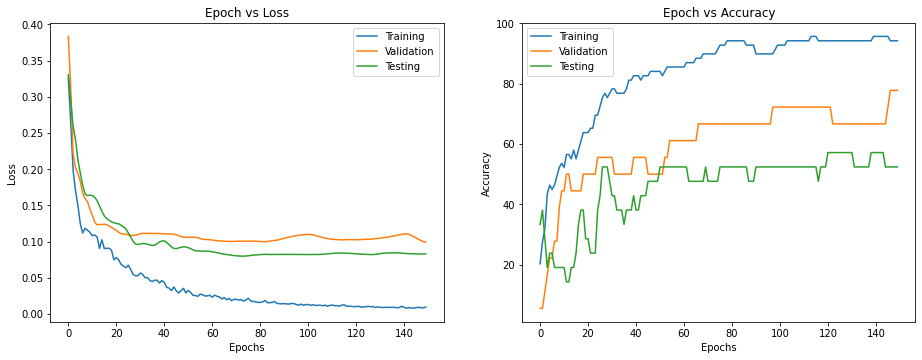


2/5 Fold
----------------------------


-----Epoch  10 / 150
Train/Val/TEST MSE: 0.11155216842889785 0.14131776160664028 0.1601244712337142
Train/Val/TEST Accuracy: 60.869565217391305 38.888888888888886 23.80952380952381
-----Epoch  20 / 150
Train/Val/TEST MSE: 0.07556599974632264 0.11317252512607309 0.1452416330132456
Train/Val/TEST Accuracy: 65.21739130434783 33.333333333333336 28.571428571428573
-----Epoch  30 / 150
Train/Val/TEST MSE: 0.05784072652459145 0.11278886503229539 0.1190065008898576
Train/Val/TEST Accuracy: 81.15942028985508 33.333333333333336 28.571428571428573
-----Epoch  40 / 150
Train/Val/TEST MSE: 0.04262508526444435 0.1007497488365819 0.12096855643072299
Train/Val/TEST Accuracy: 85.5072463768116 33.333333333333336 33.333333333333336
-----Epoch  50 / 150
Train/Val/TEST MSE: 0.02613238859921694 0.09969867543420857 0.12094732809678785
Train/Val/TEST Accuracy: 91.30434782608695 33.333333333333336 33.333333333333336
-----Epoch  60 / 150
Train/Val/TEST MSE: 0.021193787828087805 0.09331856777943257 0.11325990433

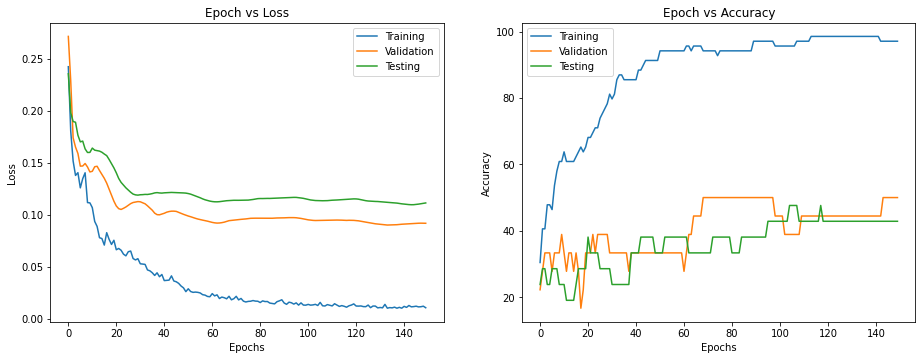


3/5 Fold
----------------------------


-----Epoch  10 / 150
Train/Val/TEST MSE: 0.12772711366415024 0.15361574598971536 0.1594911656741585
Train/Val/TEST Accuracy: 50.0 41.1764705882353 19.047619047619047
-----Epoch  20 / 150
Train/Val/TEST MSE: 0.07226893231272698 0.14114450992030256 0.1444446508373533
Train/Val/TEST Accuracy: 52.857142857142854 47.05882352941177 14.285714285714286
-----Epoch  30 / 150
Train/Val/TEST MSE: 0.062030645459890364 0.11360494704807506 0.11693540973854917
Train/Val/TEST Accuracy: 68.57142857142857 47.05882352941177 23.80952380952381
-----Epoch  40 / 150
Train/Val/TEST MSE: 0.045216456055641174 0.11387831794426721 0.12483724472778183
Train/Val/TEST Accuracy: 72.85714285714286 47.05882352941177 28.571428571428573
-----Epoch  50 / 150
Train/Val/TEST MSE: 0.035336175560951234 0.0994453542482327 0.11532373307272792
Train/Val/TEST Accuracy: 81.42857142857143 58.8235294117647 33.333333333333336
-----Epoch  60 / 150
Train/Val/TEST MSE: 0.030280278250575065 0.0978138616637272 0.12528649921573343
Train/Val

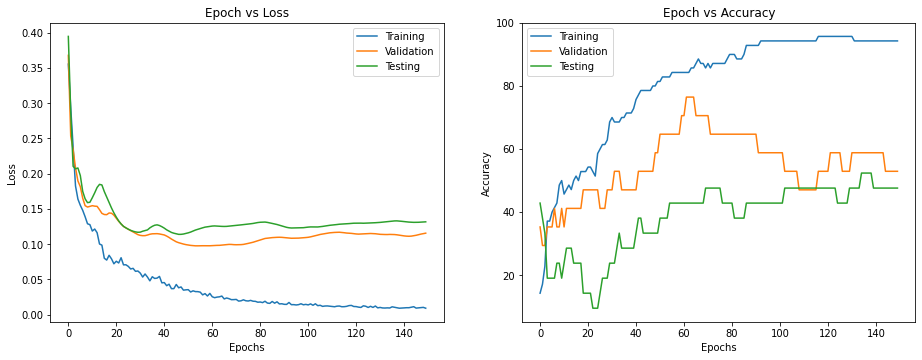


4/5 Fold
----------------------------


-----Epoch  10 / 150
Train/Val/TEST MSE: 0.0994034081697464 0.1332540489075815 0.16515747568614425
Train/Val/TEST Accuracy: 51.42857142857143 35.294117647058826 28.571428571428573
-----Epoch  20 / 150
Train/Val/TEST MSE: 0.06817533299326897 0.12071630424436401 0.12304554846403855
Train/Val/TEST Accuracy: 67.14285714285714 41.1764705882353 33.333333333333336
-----Epoch  30 / 150
Train/Val/TEST MSE: 0.045725882053375244 0.10631069727241993 0.1310667512672288
Train/Val/TEST Accuracy: 80.0 29.41176470588235 38.095238095238095
-----Epoch  40 / 150
Train/Val/TEST MSE: 0.03075334131717682 0.10224849429419812 0.11410320328459853
Train/Val/TEST Accuracy: 90.0 23.529411764705884 47.61904761904762
-----Epoch  50 / 150
Train/Val/TEST MSE: 0.024742604419589042 0.1013941044015262 0.11014453654310533
Train/Val/TEST Accuracy: 91.42857142857143 47.05882352941177 42.857142857142854
-----Epoch  60 / 150
Train/Val/TEST MSE: 0.020478639379143716 0.09944076480785631 0.10934467884224086
Train/Val/TEST Accura

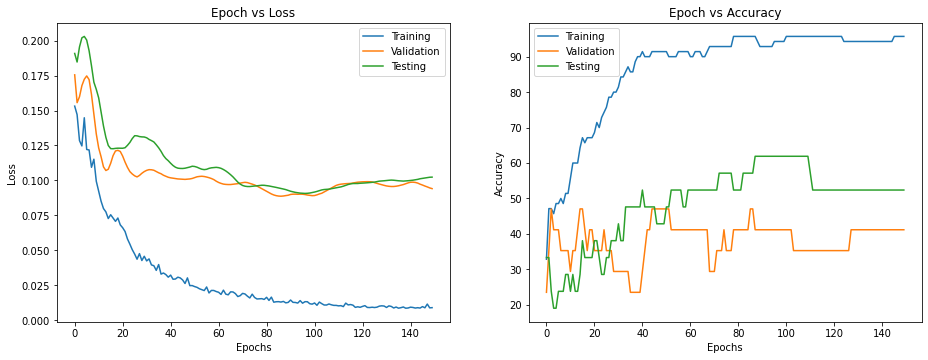


5/5 Fold
----------------------------


-----Epoch  10 / 150
Train/Val/TEST MSE: 0.12299732863903046 0.16016279029495575 0.16480215590092398
Train/Val/TEST Accuracy: 54.285714285714285 47.05882352941177 14.285714285714286
-----Epoch  20 / 150
Train/Val/TEST MSE: 0.07204360514879227 0.1324235338936834 0.16201390512287617
Train/Val/TEST Accuracy: 62.857142857142854 52.94117647058823 38.095238095238095
-----Epoch  30 / 150
Train/Val/TEST MSE: 0.053951017558574677 0.12146249380620087 0.1173684782392922
Train/Val/TEST Accuracy: 72.85714285714286 58.8235294117647 57.142857142857146
-----Epoch  40 / 150
Train/Val/TEST MSE: 0.0411228209733963 0.10621867334360585 0.10033477325036767
Train/Val/TEST Accuracy: 80.0 58.8235294117647 52.38095238095238
-----Epoch  50 / 150
Train/Val/TEST MSE: 0.033663677796721456 0.0978521833963254 0.11143370604674731
Train/Val/TEST Accuracy: 82.85714285714286 70.58823529411765 57.142857142857146
-----Epoch  60 / 150
Train/Val/TEST MSE: 0.027574336156249046 0.08099757332135649 0.08828554311323733
Train/Val

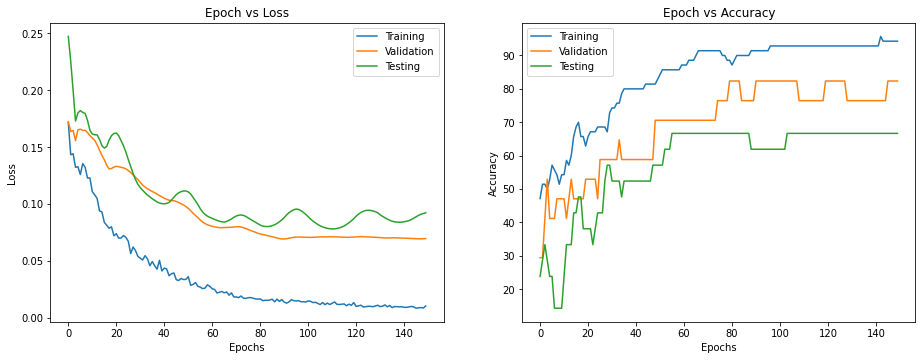

Train/Val/Test Final MSE: [0.01030405070632696, 0.0696282361579292, 0.09225483011409995]
Train/Val/Test Maximum Accuracy: [95.71428571428571, 82.3529411764706, 66.66666666666667]


In [25]:
# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args,
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)



In [26]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.00973661858588457, 0.09408391469831233, 0.10415896675992933]
Train/Val/Test Average Accuracy: [96.26915113871635, 66.73202614379085, 57.142857142857146]


## Single prediction results

In [27]:
# Print single prediction results from data loader
fold = 0
ShowDataset = TestDataLoader
ShowModel = models_K[fold]
BATCH_SHOW = 20

ShowModel.eval()

with torch.no_grad():
    for idx, (data, target) in enumerate(ShowDataset):
        data, target = data.type(torch.float).to(args['device']), target.type(torch.float).to(args['device'])
        output = ShowModel(data)
            
        eval_loss = criterion(output, target).item()
            
        predicted = maximum_extraction(output)
        labels = maximum_extraction(target)
        eval_acc = maximum_comparison(predicted, labels) * 100.0 / target.size(0)
        
        if idx < BATCH_SHOW:
            print('Batch', idx + 1, ' ( Size', target.size(0), '):')
            print('Output Example:', output[0].detach().numpy(), 'with label ', predicted[0])
            print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
            print('------- MSE:', eval_loss, ' Accuracy:', eval_acc, '%-------\n')
        else:
            print('Etc. for totally ', len(ShowDataset), 'batches.')
            break
 

Batch 1  ( Size 1 ):
Output Example: [1.9716395e-03 9.8460704e-01 9.1454224e-04 5.8123963e-03] with label  [1]
Target Example: [0.         1.         0.11111111 0.        ] with label  [1]
------- MSE: 0.0031044743955135345  Accuracy: 100.0 %-------

Batch 2  ( Size 1 ):
Output Example: [9.7387630e-01 1.8561062e-04 4.4471938e-02 3.9193597e-02] with label  [0]
Target Example: [1. 0. 1. 0.] with label  [0, 2]
------- MSE: 0.22881312668323517  Accuracy: 100.0 %-------

Batch 3  ( Size 1 ):
Output Example: [0.22372769 0.12517159 0.6081863  0.66868335] with label  [3]
Target Example: [0.7777778  0.         0.22222222 0.        ] with label  [0]
------- MSE: 0.22968627512454987  Accuracy: 0.0 %-------

Batch 4  ( Size 1 ):
Output Example: [0.03746577 0.04810544 0.4958894  0.01766316] with label  [2]
Target Example: [0.         0.         0.44444445 0.7777778 ] with label  [3]
------- MSE: 0.14603465795516968  Accuracy: 0.0 %-------

Batch 5  ( Size 1 ):
Output Example: [0.03769951 0.8270297 